In [1]:
import torch
import torch.nn as nn
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-10
EPOCHS = 3

LR = 1e-3

BATCH_SIZE = 120
MAX_PHYSICAL_BATCH_SIZE = 256
from torchvision.models.mobilenet import mobilenet_v2

In [2]:
60000/417

143.88489208633092

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms



DATA_ROOT = '../mnist'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = MNIST(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(len(train_dataset))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images[0].size()

Files already downloaded and verified
50000


torch.Size([3, 32, 32])

In [4]:
import numpy as np
import torch.optim as optim
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()
            

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.5f}, δ = {DELTA})"
                )
    return np.mean(top1_acc), epsilon
    

In [5]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)


from tqdm.notebook import tqdm

report = []

def accuracy(preds, labels):
    return (preds == labels).mean()

#for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
#    results = train(model, train_loader, optimizer, epoch + 1, device)
#    report.append(results)

In [6]:
from opacus import PrivacyEngine
import torch
from torch import nn
from torchvision import models
from opacus.validators import ModuleValidator
model = models.resnet18(num_classes=10)

In [7]:
import pandas as pd
G_h =['eps_check','distortion','clip','q','k','theta']
GU_h =['eps_check','distortion','clip','q', 'a', 'b', 'k','theta']
#G250 = pd.read_csv("../arguments/G250_values.csv", names = G_h)
GU250 = pd.read_csv("../arguments/GU_values.csv", names=GU_h)
#N250 = pd.read_csv("../arguments/N250_values.csv")

In [8]:
GU250 = GU250.sort_values("eps_check")
GU250.replace([np.inf, -np.inf], np.nan, inplace=True)
GU250 = GU250.dropna()
GU250 = GU250.reset_index()

In [9]:
GU250['eps_check'][69313]

2.99917892702162

In [10]:
GU250.loc[(GU250['eps_check']  < 1) & (GU250['distortion']  < 0.001)]

,index,eps_check,distortion,clip,q,a,b,k,theta
0,0,0.066010,0.000020,0.100000,0.002,0.000000,0.000010,1.000010,0.000010
1,1,0.066010,0.000020,0.100000,0.002,0.000000,0.000010,1.033401,0.000010
2,2,0.066010,0.000021,0.100000,0.002,0.000000,0.000010,1.000010,0.000011
3,3,0.066010,0.000023,0.100000,0.002,0.000000,0.000013,1.000010,0.000010
4,4,0.066010,0.000021,0.100000,0.002,0.000000,0.000010,1.033401,0.000011
...,...,...,...,...,...,...,...,...,...
33711,33711,0.445724,0.000999,0.164755,0.002,0.000010,0.000029,1.033401,0.000970
33714,33714,0.445771,0.000992,0.164755,0.002,0.000017,0.000022,1.033401,0.000970
33740,33740,0.446356,0.000999,0.164755,0.002,0.000013,0.000029,1.033401,0.000970
33772,33772,0.447183,0.000999,0.164755,0.002,0.000017,0.000029,1.033401,0.000970


In [11]:
acc_plrv_2 = []
from torchvision.models.mobilenet import mobilenet_v2
for i in [33808, 0]:
    torch.cuda.empty_cache()
    args ={
        "a1":1,
        "a3":1,
        "a4":1,
        "lam":1,
        "moment":1,
        "theta":GU250['theta'][i],
        'k':GU250['k'][i],
        'mu':0,
        'sigma':0.5,
        'a':GU250['a'][i],
        'b':GU250['b'][i],
        'u':1,
        'l':0.1,
        'epsilon':1,
        'max_grad_norm': GU250['clip'][i],
        'gamma':True,
        'uniform':True,
        'truncnorm':False,
    }
    print(GU250['theta'][i])
    EPOCHS = 5
    BATCH_SIZE = 120
    #print()
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms



    DATA_ROOT = '../mnist'

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = CIFAR10(
        root=DATA_ROOT, train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
    )

    test_dataset = CIFAR10(
        root=DATA_ROOT, train=False, download=True, transform=transform)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    
    #gen_args = find_values(15, i)
    runs = []
    trun = []

    model = mobilenet_v2(num_classes=10)
    #model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
    #model.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1, bias=False)
    #model.load_state_dict(dic)
    #model.train()


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModuleValidator.fix(model)
    model = model.to(device)

    privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')

    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    print("Begin training " + str(i))
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier = 1,
            epochs=EPOCHS,
            target_epsilon=3,
            target_delta=DELTA,
            max_grad_norm=GU250['clip'][i],
            PLRV_args=args,
    )

    plrv_report_acc = []
    plrv_report_ep = []

    for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
        acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
        plrv_report_acc.append(acc)
        plrv_report_ep.append(ep)

    acc_plrv_2.append((plrv_report_acc, plrv_report_ep))
    del model
    del optimizer
    #del results
#    torch.cuda.empty_cache()

0.0009700240534092
Files already downloaded and verified
Files already downloaded and verified
Begin training 33808


/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

/home/knil/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


200
	Train Epoch: 1 	Loss: 2.386589 Acc@1: 10.154667 (ε = 0.06641, δ = 1e-10)


/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/accountants/analysis/rdp_plrv.py:191: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


400
	Train Epoch: 1 	Loss: 2.402046 Acc@1: 10.153937 (ε = 0.08697, δ = 1e-10)
617
	Train Epoch: 2 	Loss: 2.437017 Acc@1: 9.672232 (ε = 0.12443, δ = 1e-10)
817
	Train Epoch: 2 	Loss: 2.452425 Acc@1: 9.794937 (ε = 0.15899, δ = 1e-10)
1034
	Train Epoch: 3 	Loss: 2.483047 Acc@1: 9.946174 (ε = 0.19648, δ = 1e-10)
1234
	Train Epoch: 3 	Loss: 2.496631 Acc@1: 10.002260 (ε = 0.23104, δ = 1e-10)
1451
	Train Epoch: 4 	Loss: 2.507908 Acc@1: 9.823690 (ε = 0.26853, δ = 1e-10)
1651
	Train Epoch: 4 	Loss: 2.497934 Acc@1: 10.062206 (ε = 0.30308, δ = 1e-10)
1868
	Train Epoch: 5 	Loss: 2.518046 Acc@1: 9.830612 (ε = 0.34057, δ = 1e-10)
2068
	Train Epoch: 5 	Loss: 2.535402 Acc@1: 9.886234 (ε = 0.37513, δ = 1e-10)
1e-05
Files already downloaded and verified
Files already downloaded and verified
Begin training 0


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

200
	Train Epoch: 1 	Loss: 2.422625 Acc@1: 12.415090 (ε = 0.06629, δ = 1e-10)
400
	Train Epoch: 1 	Loss: 2.235542 Acc@1: 16.632730 (ε = 0.06629, δ = 1e-10)
617
	Train Epoch: 2 	Loss: 1.996653 Acc@1: 28.167243 (ε = 0.06629, δ = 1e-10)
817
	Train Epoch: 2 	Loss: 2.037212 Acc@1: 30.715218 (ε = 0.06629, δ = 1e-10)
1034
	Train Epoch: 3 	Loss: 2.227584 Acc@1: 36.338941 (ε = 0.06629, δ = 1e-10)
1234
	Train Epoch: 3 	Loss: 2.276030 Acc@1: 37.296491 (ε = 0.06629, δ = 1e-10)
1451
	Train Epoch: 4 	Loss: 2.508211 Acc@1: 40.641703 (ε = 0.06629, δ = 1e-10)
1651
	Train Epoch: 4 	Loss: 2.542803 Acc@1: 41.266044 (ε = 0.06629, δ = 1e-10)
1868
	Train Epoch: 5 	Loss: 2.635273 Acc@1: 43.339508 (ε = 0.06629, δ = 1e-10)
2068
	Train Epoch: 5 	Loss: 2.655223 Acc@1: 43.712371 (ε = 0.06629, δ = 1e-10)


In [13]:
acc_plrv_2 = [[(26.031835, 0.06629), 
              (9.886989, 0.45468),
              (10.372164, 0.74685),
              (10.037741, 1.06397),
              (10.192874, 1.39833),
              ], [(12.908223,0.06629),
              (29.109944, 0.06630),
              (35.943574, 0.06631),
              (40.175252, 0.06632),
              (43.476607, 0.06635),]
             ]

In [ ]:
GU250.head(-1)

In [ ]:
acc_plrv = []
for i in range(1, len(GU250), int(len(GU250)/10)):
    torch.cuda.empty_cache()
    args ={
        "a1":1,
        "a3":1,
        "a4":1,
        "lam":1,
        "moment":1,
        "theta":GU250['theta'][i],
        'k':GU250['k'][i],
        'mu':0,
        'sigma':0.5,
        'a':GU250['a'][i],
        'b':GU250['b'][i],
        'u':1,
        'l':0.1,
        'epsilon':1,
        'max_grad_norm': GU250['b'][i],
        'gamma':True,
        'uniform':False,
        'truncnorm':False,
    }
    
    #gen_args = find_values(15, i)
    runs = []
    trun = []

    model = mobilenet_v2(num_classes=10)
    #model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
    #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    #model.load_state_dict(dic)
    #model.train()


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModuleValidator.fix(model)
    model = model.to(device)

    privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')

    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    print("Begin training " + str(i))
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier = 1,
            epochs=10,
            target_epsilon=0.15,
            target_delta=DELTA,
            max_grad_norm=GU250['clip'][i],
            PLRV_args=args,
    )

    plrv_report_acc = []
    plrv_report_ep = []

    for epoch in tqdm(range(5), desc="Epoch", unit="epoch"):
        acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
        plrv_report_acc.append(acc)
        plrv_report_ep.append(ep)

    acc_plrv.append((G250['distortion'][i], test(model, test_loader, device)))
    del model
    del optimizer
    #del results
#    torch.cuda.empty_cache()

In [ ]:
acc_plrv

In [ ]:
g_eps = pd.read_csv('../arguments/gaussian_eps.csv', names = ['eps'])
g_dist = pd.read_csv('../arguments/gaussian_dist.csv', names = ['distortion'])
g_clip = pd.read_csv('../arguments/gaussian_clip.csv', names = ['clip'])

In [ ]:
g_clip = g_clip.dropna()
g_clip = g_clip.reset_index()

In [ ]:
acc_rdp = []
from torchvision.models.mobilenet import mobilenet_v2
for i in [0.3, 100]:
    print(i)
    #gen_args = find_values(15, i)
    runs = []
    trun = []

    model = mobilenet_v2(num_classes=10)
    #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    #model.load_state_dict(dic)
    #model.train()


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModuleValidator.fix(model)
    model = model.to(device)
    
    privacy_engine = PrivacyEngine(accountant = 'rdp')

    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    print("Begin training " + str(i))
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            #noise_multiplier = 1,
            epochs=5,
            target_epsilon=i,
            target_delta=1e-5,
            max_grad_norm=10,
            #PLRV_args=convert_params(gen_args),
    )

    plrv_report_acc = []
    plrv_report_ep = []

    for epoch in tqdm(range(5), desc="Epoch", unit="epoch"):
        acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
        plrv_report_acc.append(acc)
        plrv_report_ep.append(ep)

    acc_rdp.append((plrv_report_acc, plrv_report_ep))
    del model
    del optimizer
    #del results
    torch.cuda.empty_cache()

In [14]:
acc_rdp = [[(10.306089,0.56131), 
              (10.231322,0.57970),
              (10.162706,0.59808),
              (10.364808,0.61647),
              (10.803952,0.63486),
              ], [(13.559350,91.20878),
              (20.861802,108.71947),
              (26.686870,126.23016),
              (30.309798,143.74085),
              (32.346740,157.19585),]
             ]

In [ ]:

model = models.resnet18(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = ModuleValidator.fix(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')

optimizer = optim.RMSprop(model.parameters(), lr=LR)
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier = 1,
            epochs=10,
            target_epsilon=0.15,
            target_delta=DELTA,
            max_grad_norm=GU250['clip'][i],
            PLRV_args=args,
    )
dic = model.state_dict()

In [ ]:
del model

In [ ]:
acc_plrv_2.sort()
acc_rdp.sort()
dist_x = [i[0] for i in acc_plrv_2]
acc_y = [i[1] for i in acc_plrv_2]
dist_g = [i[0] for i in acc_rdp]
acc_g = [i[1] for i in acc_rdp]
import matplotlib.pyplot as plt
plt.xlabel("distortion")
plt.ylabel("Accuracy")
plt.title("distortion vs accuracy")
plt.yscale('log')
fig, ax1 = plt.subplots()
ax1.plot(dist_x, acc_y, 'bo-', label="PLRV")
ax1.set_ylabel("Accuracy")
#ax1.set_yscale('log')
ax2 = ax1.twiny()
ax2.plot(dist_g, acc_g, 'ro-', label="Guassian")
#ax2.set_yscale('log')
plt.legend(loc="lower right")
plt.show()

In [ ]:
acc_plrv_2.sort()
acc_rdp.sort()
dist_x = [i[2] for i in acc_plrv_2]
acc_y = [i[1] for i in acc_plrv_2]
dist_g = [i[0] for i in acc_rdp]
acc_g = [i[1] for i in acc_rdp]
import matplotlib.pyplot as plt
plt.xlabel("distortion")
plt.ylabel("Accuracy")
plt.title("distortion vs accuracy")
plt.yscale('log')
fig, ax1 = plt.subplots()
ax1.plot(dist_x, acc_y, 'bo-', label="PLRV")
ax1.set_ylabel("Accuracy")
ax1.set_xscale('log')
ax2 = ax1.twiny()
ax2.plot(dist_g, acc_g, 'ro-', label="Guassian")
#ax2.set_yscale('log')
plt.legend(loc="lower right")
plt.show()

[[(26.031835, 0.06629), (9.886989, 0.45468), (10.372164, 0.74685), (10.037741, 1.06397), (10.192874, 1.39833)], [(12.908223, 0.06629), (29.109944, 0.0663), (35.943574, 0.06631), (40.175252, 0.06632), (43.476607, 0.06635)]]
[[(10.306089, 0.56131), (10.231322, 0.5797), (10.162706, 0.59808), (10.364808, 0.61647), (10.803952, 0.63486)], [(13.55935, 91.20878), (20.861802, 108.71947), (26.68687, 126.23016), (30.309798, 143.74085), (32.34674, 157.19585)]]


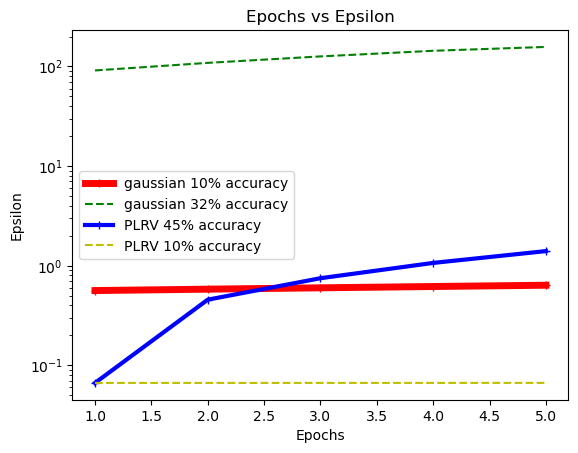

In [15]:
#acc_plrv_2.sort()
#acc_rdp.sort()
x_vals = range(1,6)
print(acc_plrv_2)
plrv1 = [i[1] for i in acc_plrv_2[0]]
plrv2 = [i[1] for i in acc_plrv_2[1]]
print(acc_rdp)
g1 = [i[1] for i in acc_rdp[0]]
g2 = [i[1] for i in acc_rdp[1]]
import matplotlib.pyplot as plt
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.title("Epochs vs Epsilon")
#plt.plot(x_vals, plrv1, 'b+-', label="PLRV 45% accuracy")
#plt.plot(x_vals, plrv2, 'bo--', label="PLRV 10% accuracy")
plt.plot(x_vals, g1, 'r+-', label="gaussian 10% accuracy", linewidth=5)
plt.plot(x_vals, g2, 'g--', label="gaussian 32% accuracy")
plt.plot(x_vals, plrv1, 'b+-', label="PLRV 1% accuracy", linewidth=3)
plt.plot(x_vals, plrv2, 'y--', label="PLRV 43% accuracy")
plt.yticks(np.logspace(0, 200, 5))
plt.yscale("log")
plt.legend(loc="best")
plt.show()

In [ ]:
acc_plrv = []
for i in range(1, 11):
    gen_args = find_values(13, i)
    runs = []
    trun = []

    #model = models.resnet18(num_classes=10)
    #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.load_state_dict(dic)
    model.train()


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')

    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    print("Begin training " + str(i))
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier = 1,
            epochs=EPOCHS,
            target_epsilon=0.15,
            target_delta=DELTA,
            max_grad_norm=i+1,
            PLRV_args=convert_params(gen_args),
    )

    plrv_report_acc = []
    plrv_report_ep = []

    for epoch in tqdm(range(1), desc="Epoch", unit="epoch"):
        acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
        plrv_report_acc.append(acc)
        plrv_report_ep.append(ep)

    acc_plrv.append(test(model, test_loader, device))
#    del model
    del optimizer
    #del results
#    torch.cuda.empty_cache()

In [ ]:
3**False